# Suscripción de clientes de bancos portugueses a un depósito trimestral (Producto)

## Campaña de marketing

1. Fuentes
   Created by: Paulo Cortez (Univ. Minho) and Sérgio Moro (ISCTE-IUL) @ 2012
   
2. Uso pasado:

      El conjunto de datos completo fue descrito y analizado por:

      S. Moro, R. Laureano y P. Cortez. Utilización de la Minería de Datos para el Marketing Directo Bancario: Una Aplicación de la Metodología CRISP-DM.
      En P. Novais et al. (Eds.), Actas de la Conferencia Europea de Simulación y Modelado - ESM'2011, pp. 117-121, Guimarães, Portugal, octubre de 2011. EUROSIS.

3. Información relevante:

   Los datos están relacionados con campañas de marketing de una institución portuguesa de bancos. 
   Las campañas de marketing fueron realizadas por llamadas móviles.A menudo,se requirió más de un contacto al mismo cliente para determinar si el producto (depósito trimestral bancario) sería o no suscrito. 

   El objetivo es predecir si el client se suscribirá a esa subscripción (variable y en el csv).

4. Número de filas: 45211

5. Numero de variables: 16 + salida.

## Descripción de las variables.


* age (numeric)
* job : type of job (categorical: "admin","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* education (categorical: "unknown","secondary","primary","tertiary")
* default: has credit in default? (binary: "yes","no")
* balance: average yearly balance, in euros (numeric) 
* housing: has housing loan? (binary: "yes","no")
* loan: has personal loan? (binary: "yes","no")

Related with the last contact of the current campaign:
* contact: contact communication type (categorical: "unknown","telephone","cellular") 
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* duration: last contact duration, in seconds (numeric)

ther attributes:
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
* y - has the client subscribed a term deposit? (binary: "yes","no")

## Para este caso vamos a usar un modelo neuronal.

# Carga del csv.

Cargamos el csv que esta alojado en mi repositorio de github, para este caso los datos a tratar es un csv que viene con las características anteriormente dichas.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler

url = 'https://raw.githubusercontent.com/alexander6779/SNS/main/Final_Project/bank_data/'

df = pd.read_csv(url+'bank-full.csv',sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# Transformación de datos

In [65]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Podemos observar que no hay ningún valor nulo, por tanto no tendremos que rellenar dichos valores.

In [66]:
months = {'jan':0,'feb':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11}
job = {'admin.':0,'unknown':1,'unemployed':2,'management':3,'housemaid':4,'entrepreneur':5,'student':6,'blue-collar':7,'self-employed':8,'retired':9,'technician':10,'services':11}
marital = {'married':0,'divorced':1,'single':2}
housing = {'no':0,'yes':1}
loan = {'no':0,'yes':1}
default = {'no':0,'yes':1}
education = {'unknown':0,'primary':1,'secondary':2,'tertiary':3}
contact = {'unknown':0,'telephone':1,'cellular':2}
poutcome = {'unknown':0,'success':1,'failure':2,'other':3}

In [67]:
def fromCatToNum(datafr):
    cols = ['month','job','marital','housing','loan','default','education','contact','poutcome']
    values = {'month':months,'job':job,'marital':marital,'housing':housing,'loan':loan,'default':default,'education':education,'contact':contact,'poutcome':poutcome}
    for i in datafr:
        if i in cols:
            datafr[i] = datafr[i].map(values[i])
fromCatToNum(df)

# Separación de datos y escalamiento de los mismos

Separamos los datos para train y test de manera que 20% va a ser test y 80% train.
Separo la Y de la X para escalar y posteriormente dividir entre train y test.

In [68]:
from keras.utils import to_categorical
X = df.copy()
y = X['y']
y = y.replace({"no": 0, "yes": 1})
y = to_categorical(y)
X.drop('y', axis=1 ,inplace=True)

Muestro los datos antes de escalar.

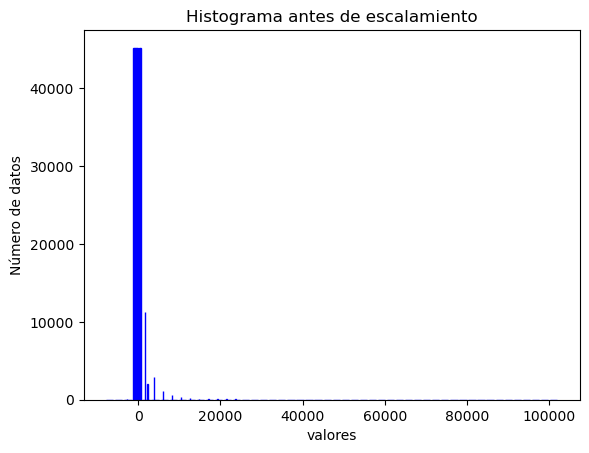

In [69]:
plt.hist(X, 50, edgecolor='blue')
plt.ylabel('Número de datos')
plt.xlabel('valores')
plt.title('Histograma antes de escalamiento')
plt.show()

Escalo toda la X.

In [70]:
scaler =MaxAbsScaler()
X[X.columns] = scaler.fit_transform(X)
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0.61,0.27,0.00,1.00,0.00,0.02,1.00,0.00,0.00,0.16,0.36,0.05,0.02,-0.00,0.00,0.00
1,0.46,0.91,1.00,0.67,0.00,0.00,1.00,0.00,0.00,0.16,0.36,0.03,0.02,-0.00,0.00,0.00
2,0.35,0.45,0.00,0.67,0.00,0.00,1.00,1.00,0.00,0.16,0.36,0.02,0.02,-0.00,0.00,0.00
3,0.49,0.64,0.00,0.00,0.00,0.01,1.00,0.00,0.00,0.16,0.36,0.02,0.02,-0.00,0.00,0.00
4,0.35,0.09,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.36,0.04,0.02,-0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.54,0.91,0.00,1.00,0.00,0.01,0.00,0.00,1.00,0.55,0.91,0.20,0.05,-0.00,0.00,0.00
45207,0.75,0.82,0.50,0.33,0.00,0.02,0.00,0.00,1.00,0.55,0.91,0.09,0.03,-0.00,0.00,0.00
45208,0.76,0.82,0.00,0.67,0.00,0.06,0.00,0.00,1.00,0.55,0.91,0.23,0.08,0.21,0.01,0.33
45209,0.60,0.64,0.00,0.67,0.00,0.01,0.00,0.00,0.50,0.55,0.91,0.10,0.06,-0.00,0.00,0.00


Vuelvo a mostrar los datos pero ahora escalados.

In [ ]:
plt.hist(X, 50, edgecolor='blue')
plt.ylabel('Número de datos')
plt.xlabel('valores')
plt.title('Histograma despues de escalamiento')
plt.show()

Por último divido los datos entre train y test.

In [71]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


x_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =42)

De los datos de train voy a coger u 5% para validar durante el entrenamiento no obtener valores dispares.

In [72]:
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train,test_size=0.05,random_state =42)

# Creación y entrenamiento del modelo neuronal

In [73]:
from tensorflow import keras
from tensorflow.keras import layers


# Definir el modelo
model = keras.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))  # Capa de entrada
model.add(layers.Dense(64, activation='relu'))  # Capa oculta
model.add(layers.Dense(2, activation='softmax'))  # Capa de salida con activación softmax

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con datos de ejemplo
train_log = model.fit(x_train, y_train, epochs=10, batch_size=20, validation_data=(x_val,y_val))

Epoch 1/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.2917 - accuracy: 0.8879 - val_loss: 0.2610 - val_accuracy: 0.8894
Epoch 2/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2471 - accuracy: 0.8969 - val_loss: 0.2522 - val_accuracy: 0.8939
Epoch 3/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2417 - accuracy: 0.8980 - val_loss: 0.2465 - val_accuracy: 0.8944
Epoch 4/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2384 - accuracy: 0.8992 - val_loss: 0.2458 - val_accuracy: 0.8955
Epoch 5/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2360 - accuracy: 0.8984 - val_loss: 0.2412 - val_accuracy: 0.8988
Epoch 6/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2330 - accuracy: 0.8996 - val_loss: 0.2415 - val_accuracy: 0.8933
Epoch 7/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.2311 - accuracy: 0.9002 - val_loss: 0.2340 - val_accuracy:

# Comprobación del porcentaje de pérdida y de precisión

In [74]:
# Evaluar el modelo con datos de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)

283/283 [==============================] - 0s 1ms/step - loss: 0.2325 - accuracy: 0.8973


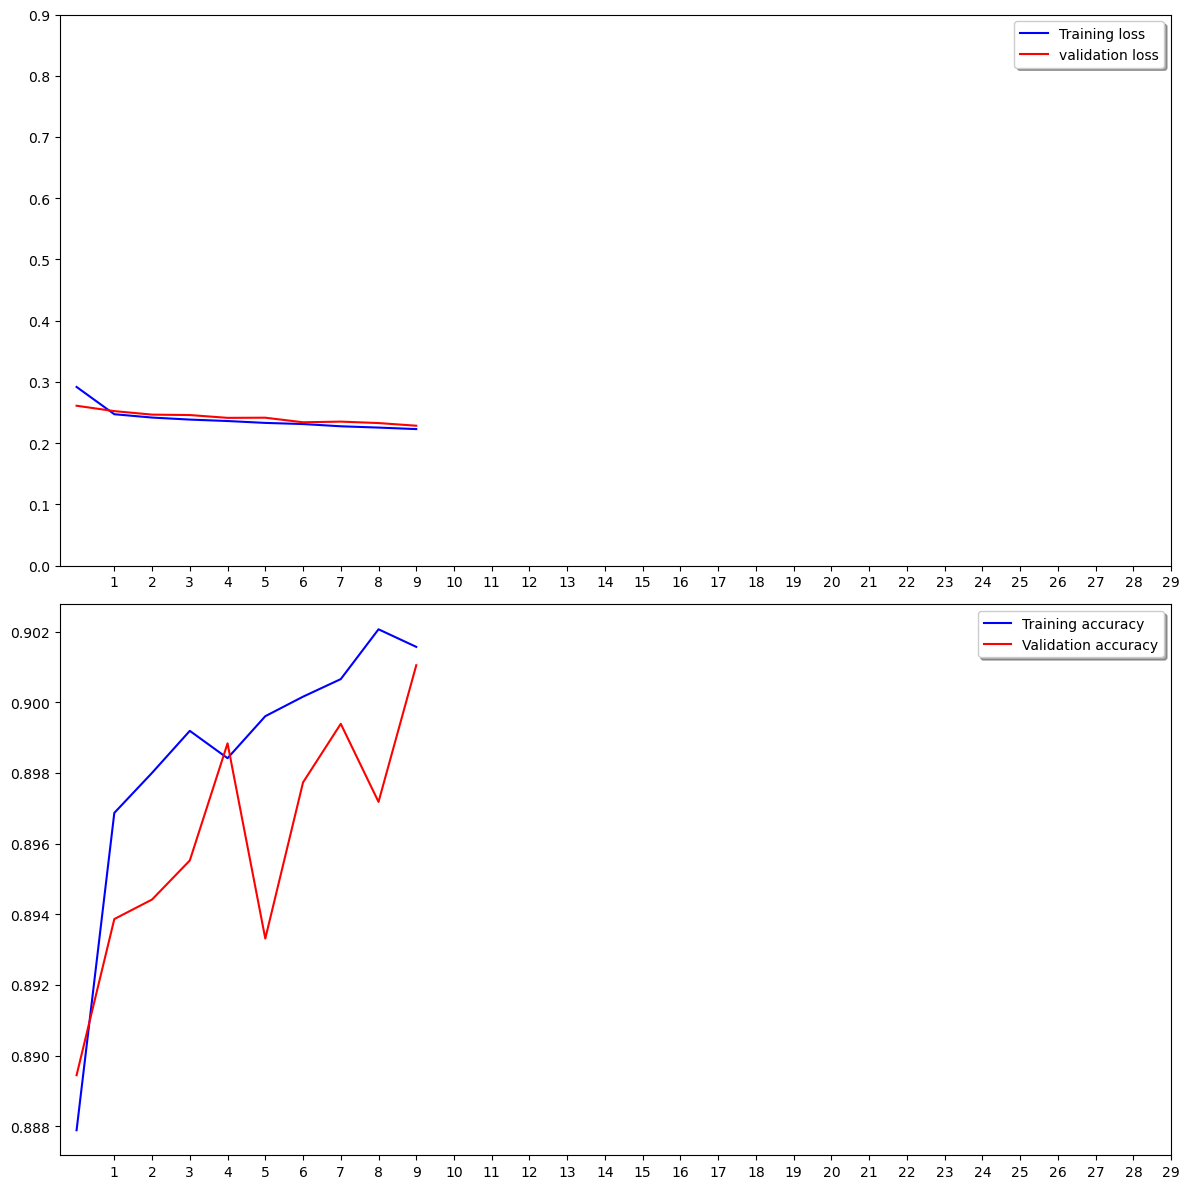

In [75]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(train_log.history['loss'], color='b', label="Training loss")
ax1.plot(train_log.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)
ax2.plot(train_log.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train_log.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [76]:
# Realizar predicciones con nuevos datos
y_pred = model.predict(X_test)
y_pred

283/283 [==============================] - 0s 1ms/step


array([[9.9927908e-01, 7.2097580e-04],
       [9.9892682e-01, 1.0731325e-03],
       [9.0380597e-01, 9.6194044e-02],
       ...,
       [9.9579263e-01, 4.2073210e-03],
       [9.9949038e-01, 5.0958304e-04],
       [9.9836761e-01, 1.6323724e-03]], dtype=float32)

In [80]:
results = []

for i in range(len(y_pred)):
    results.append(np.argmax(y_pred[i]))


# Matriz de Confusión

Generamos la matriz de confusión para poder constrastar los datos de la predicción con los reales, pudiendo ver cuánto ha acertado.

Debido a que ya mis datos de y_test es un objeto Series con dos posibles valores uso el set de datos principal para poder constrastar los datos reales con los predichos.

In [78]:
y_check = df['y']
y_check = y_check.replace(['no','yes'],[0,1])
Xtrain,Xtest,Ytrain,Ytest = train_test_split(df.drop('y',axis=1), y_check,test_size=0.2,random_state =42)

Text(0.5, 1.0, 'Exactitud: 0.8972685933113098')

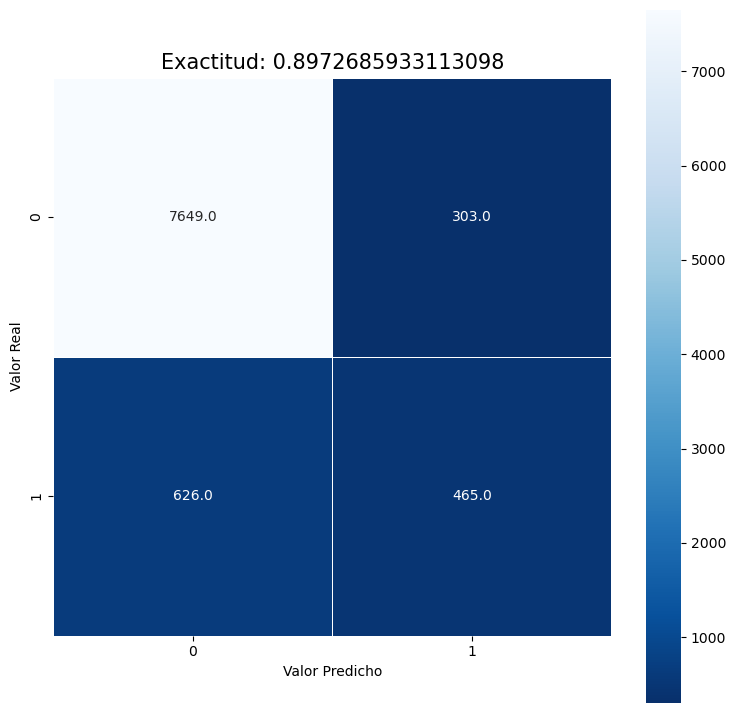

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Ytest, results,labels=[0,1])
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r',yticklabels=[0,1],xticklabels=[0,1])
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
all_sample_title = 'Exactitud: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15)

# Conclusión 

Podemos observar como el modelo neuronal es mucho más preciso que el modelo de machine learnig, no siempre suele pasar, se dan casos opuestos,pero a pesar de esto último, también es más rápido, aunque hay una pequeña anomalía, podemos ver que acierta bastantes 0 pero con 1 acierta pero encuentra más falsos positivos que el modelo LGBM Classifier, que tiende a fallar menos en ese sentido aún teniendo un poco menos de precisión. 